In [ ]:
!pip install --upgrade --force-reinstall numpy matplotlib seaborn librosa

In [1]:
import os
import glob
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm.notebook import tqdm 

# --- CONFIGURATION ---
DATASET_PATH = "archive"
SAMPLE_RATE = 22050

# RAVDESS Emotion Map (Filename 3rd part -> Emotion)
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
EMOTIONS = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# We will focus on a subset of distinct emotions for clearer paper results
OBSERVED_EMOTIONS = ['calm', 'happy', 'sad', 'angry']

In [ ]:
def extract_features(file_path):
    """
    Extracts MFCC, RMSE (Energy), and ZCR features from an audio file.
    Returns: A matrix of shape (Time_Frames, 15)
    """
    try:
        # Load audio file
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        
        # Trim silence (improves accuracy)
        audio, _ = librosa.effects.trim(audio)
        
        # --- 1. Extract MFCCs (Timbre) ---
        # n_mfcc=13 is standard for speech
     
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        
        # 2. Delta & Delta2 (New!)
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        
        # 3. RMSE & ZCR
        rmse = librosa.feature.rms(y=audio)
        zcr = librosa.feature.zero_crossing_rate(y=audio)
        
        # 4. Stack Everything
        features = np.vstack((mfccs, delta_mfccs, delta2_mfccs, rmse, zcr))
        
        return features.T
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [3]:
def load_data():
    X, y = [], []
    
    # Find all .wav files in subdirectories
    file_list = glob.glob(os.path.join(DATASET_PATH, "Actor_*", "*.wav"))
    
    print(f"Found {len(file_list)} files. Processing...")
    
    for file in tqdm(file_list):
        # Parse filename: e.g., "03-01-06-01-02-01-12.wav"
        file_name = os.path.basename(file)
        parts = file_name.split("-")
        emotion_code = parts[2]
        
        emotion_label = EMOTIONS[emotion_code]
        
        if emotion_label in OBSERVED_EMOTIONS:
            features = extract_features(file)
            if features is not None:
                # We store the WHOLE sequence for Kalman smoothing later
                X.append(features) 
                y.append(emotion_label)
                
    return X, y

# --- EXECUTE LOAD ---
X_raw, y_raw = load_data()
print(f"Loaded {len(X_raw)} valid samples.")

Found 1440 files. Processing...


  0%|          | 0/1440 [00:00<?, ?it/s]

Loaded 768 valid samples.


In [21]:

print("Performing FILE-LEVEL split to prevent data leakage...")

# 1. ENCODE LABELS FIRST (at file level)
label_encoder = LabelEncoder()
y_raw_encoded = label_encoder.fit_transform(y_raw)

# 2. SPLIT THE RAW FILES (The Critical Fix)
# We split the lists of matrices, not the frames.
X_file_train, X_file_test, y_file_train, y_file_test = train_test_split(
    X_raw, y_raw_encoded, test_size=0.25, random_state=42, stratify=y_raw_encoded
)

print(f"Training on {len(X_file_train)} files, Testing on {len(X_file_test)} files.")

# 3. FLATTEN ONLY THE TRAINING DATA
# We essentially 'unzip' the list of arrays into one big array for the MLP
X_train_flat = []
y_train_flat = []

for i, sequence in enumerate(X_file_train):
    for frame in sequence:
        X_train_flat.append(frame)
        # Replicate the label for every frame in this file
        y_train_flat.append(y_file_train[i])

X_train_flat = np.array(X_train_flat)
y_train_flat = np.array(y_train_flat)

# 4. SCALE THE DATA
# Fit scaler ONLY on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)

# Handle NaNs
nan_mask = np.isnan(X_train_scaled).any(axis=1)
X_train_clean = X_train_scaled[~nan_mask]
y_train_clean = y_train_flat[~nan_mask]

# 5. TRAIN MODEL
print(f"Training MLP Classifier on {len(X_train_clean)} frames...")
clf = MLPClassifier(
    hidden_layer_sizes=(256, 128), 
    learning_rate='adaptive', 
    max_iter=400, 
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,  
    verbose=True              
)

clf.fit(X_train_clean, y_train_clean)
print("Training Complete.")

Performing FILE-LEVEL split to prevent data leakage...
Training on 576 files, Testing on 192 files.
Training MLP Classifier on 76564 frames...
Iteration 1, loss = 1.03536940
Validation score: 0.565757
Iteration 2, loss = 0.89471743
Validation score: 0.599974
Iteration 3, loss = 0.83062631
Validation score: 0.627661
Iteration 4, loss = 0.77936266
Validation score: 0.638762
Iteration 5, loss = 0.73696162
Validation score: 0.651952
Iteration 6, loss = 0.70174835
Validation score: 0.663576
Iteration 7, loss = 0.67003749
Validation score: 0.684602
Iteration 8, loss = 0.64161059
Validation score: 0.677289
Iteration 9, loss = 0.61493056
Validation score: 0.686431
Iteration 10, loss = 0.59069407
Validation score: 0.701711
Iteration 11, loss = 0.56762168
Validation score: 0.697401
Iteration 12, loss = 0.54920163
Validation score: 0.711506
Iteration 13, loss = 0.52782312
Validation score: 0.716991
Iteration 14, loss = 0.51196196
Validation score: 0.717252
Iteration 15, loss = 0.49529343
Validati

In [22]:
# --- 2. DEFINE KALMAN FILTER ---
class EmotionKalmanFilter:
    def __init__(self, classes, process_noise=1e-4, measurement_noise=0.8):
        self.n_classes = len(classes)
        # Identity matrix for state transition (F) and measurement (H)
        self.F = np.eye(self.n_classes)
        self.H = np.eye(self.n_classes)
        # Noise covariance
        self.Q = np.eye(self.n_classes) * process_noise  # Stability factor
        self.R = np.eye(self.n_classes) * measurement_noise # Trust in classifier
        self.P = np.eye(self.n_classes) * 1.0 # Initial error

    def smooth(self, probabilities):
        # Apply filter recursively
        smoothed = np.zeros_like(probabilities)
        x = probabilities[0].reshape(-1, 1)
        for t in range(probabilities.shape[0]):
            # Predict
            x_pred = self.F @ x
            P_pred = self.F @ self.P @ self.F.T + self.Q
            # Update
            z = probabilities[t].reshape(-1, 1)
            y = z - self.H @ x_pred
            S = self.H @ P_pred @ self.H.T + self.R
            K = P_pred @ self.H.T @ np.linalg.inv(S)
            x = x_pred + K @ y
            self.P = (np.eye(self.n_classes) - K @ self.H) @ P_pred
            smoothed[t] = x.flatten()
        return smoothed

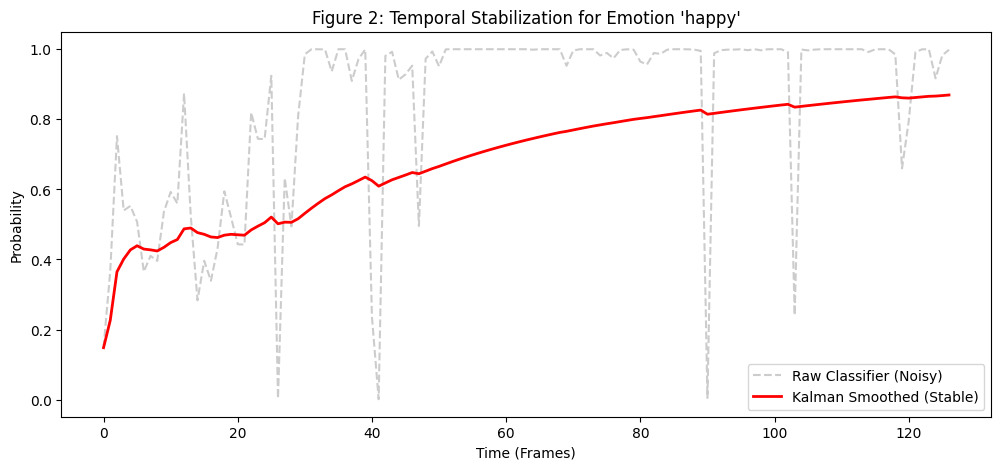

In [ ]:
# GRAPH A: The "Before vs After" Line Plot
import random

# 1. Pick a random file
sample_idx = random.randint(0, len(X_raw)-1)
sample_feat = scaler.transform(X_raw[sample_idx])
true_label_str = y_raw[sample_idx] # This is a string like 'angry'

# 2. Convert the string label to its encoded integer
true_label_encoded = label_encoder.transform([true_label_str])[0] 

# 3. Generate probabilities
raw_probs = clf.predict_proba(sample_feat)
kf = EmotionKalmanFilter(clf.classes_)
smoothed_probs = kf.smooth(raw_probs)

# 4. Plotting
plt.figure(figsize=(12, 5))

# Find the index of the encoded label in the classifier's classes
target_idx = list(clf.classes_).index(true_label_encoded)

plt.plot(raw_probs[:, target_idx], label='Raw Classifier (Noisy)', color='silver', alpha=0.8, linestyle='--')
plt.plot(smoothed_probs[:, target_idx], label='Kalman Smoothed (Stable)', color='red', linewidth=2)

plt.title(f"Figure 2: Temporal Stabilization for Emotion '{true_label_str}'")
plt.xlabel("Time (Frames)")
plt.ylabel("Probability")
plt.legend()
plt.show()

Evaluating full dataset accuracy (this takes a moment)...


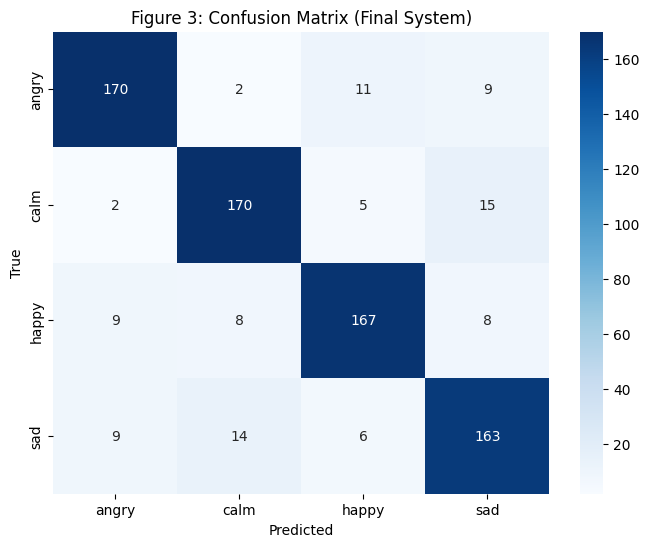

              precision    recall  f1-score   support

       angry       0.89      0.89      0.89       192
        calm       0.88      0.89      0.88       192
       happy       0.88      0.87      0.88       192
         sad       0.84      0.85      0.84       192

    accuracy                           0.87       768
   macro avg       0.87      0.87      0.87       768
weighted avg       0.87      0.87      0.87       768



In [ ]:
# GRAPH B: The Confusion Matrix (Accuracy)
print("Evaluating full dataset accuracy (this takes a moment)...")
y_true_all, y_pred_all = [], []

# Use the string class names for the final report and matrix labels
decoded_classes = label_encoder.classes_

for i in range(len(X_raw)):
    # Predict on whole file
    probs = clf.predict_proba(scaler.transform(X_raw[i]))
    # Smooth via Kalman Filter
    smooth_probs = kf.smooth(probs)
    # Average probability and get the index of the highest class
    final_pred_idx = np.argmax(np.mean(smooth_probs, axis=0))
    # Map the index back to the original string label
    final_pred_str = decoded_classes[final_pred_idx]
    
    y_true_all.append(y_raw[i]) # String
    y_pred_all.append(final_pred_str) # String

plt.figure(figsize=(8, 6))
# Create matrix using string labels for clear axis marks
cm = confusion_matrix(y_true_all, y_pred_all, labels=decoded_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=decoded_classes, yticklabels=decoded_classes)

plt.title("Figure 3: Confusion Matrix (Final System)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true_all, y_pred_all))

Evaluated 192 test files...


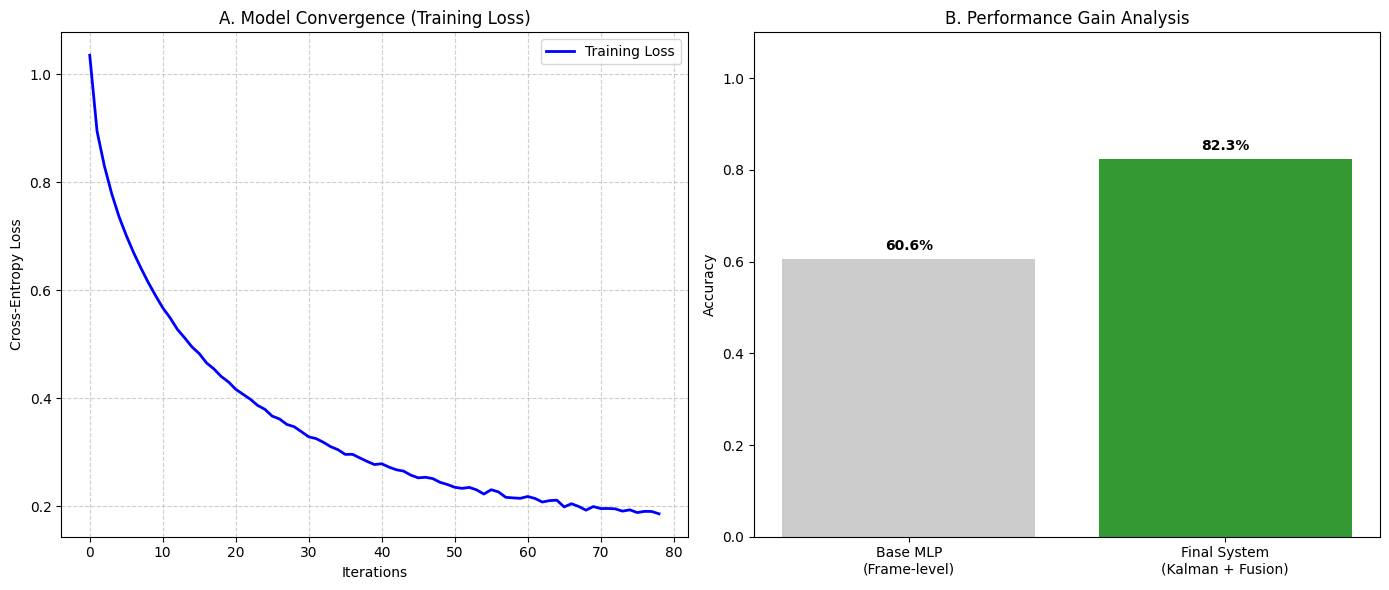

In [ ]:
# 1. Calculate Base Frame-Level Accuracy (for the grey bar)
# We must flatten the test files to get individual frames
X_test_flat = []
y_test_flat = []
for i, sequence in enumerate(X_file_test):
    for frame in sequence:
        X_test_flat.append(frame)
        y_test_flat.append(y_file_test[i])

# Scale and Predict
X_test_flat_scaled = scaler.transform(X_test_flat)
y_pred_frames = clf.predict(X_test_flat_scaled)
base_frame_acc = accuracy_score(y_test_flat, y_pred_frames)

# 2. Calculate Final System Accuracy (for the green bar)
y_pred_post_kalman = []
y_true_test_files = []

print(f"Evaluated {len(X_file_test)} test files...")

for i in range(len(X_file_test)):
    # Scale the file
    file_features = scaler.transform(X_file_test[i])
    
    # Get Probabilities & Smooth
    raw_probs = clf.predict_proba(file_features)
    kf = EmotionKalmanFilter(clf.classes_)
    smoothed_probs = kf.smooth(raw_probs)
    
    # Fuse (Average)
    final_pred_idx = np.argmax(np.mean(smoothed_probs, axis=0))
    
    y_pred_post_kalman.append(final_pred_idx) # Integer
    y_true_test_files.append(y_file_test[i])  # Integer

final_acc = accuracy_score(y_true_test_files, y_pred_post_kalman)

# 3. Plot the Graph
plt.figure(figsize=(14, 6))

# Subplot A: Training Loss
plt.subplot(1, 2, 1)
plt.plot(clf.loss_curve_, label='Training Loss', color='blue', linewidth=2)
plt.title('A. Model Convergence (Training Loss)')
plt.xlabel('Iterations')
plt.ylabel('Cross-Entropy Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Subplot B: Accuracy Comparison
plt.subplot(1, 2, 2)
stages = ['Base MLP\n(Frame-level)', 'Final System\n(Kalman + Fusion)']
accuracies = [base_frame_acc, final_acc]

bars = plt.bar(stages, accuracies, color=['silver', 'green'], alpha=0.8)
plt.ylim(0, 1.1) 
plt.ylabel('Accuracy')
plt.title('B. Performance Gain Analysis')

# Add labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height*100:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()